# Evaluating the low-rank Gaussian embeddings

This notebook shows you how to evaluate Gaussian embeddings that were pre-trained from a graph induced from the Cellular Component (CC) of the [GO](http://geneontology.org/).

Here, two evaluations are conducted to determine whether the "distances" between embeddings are able, on their own, to:

1. discriminate between ancestors and descendants relationships.

2. capture the shortest path lengths between the graph nodes represented by the embeddings.

## Preamble

In [1]:
#@title Install gGO
url = "git+https://github.com/blindcosmos/ggo.git"

# to avoid dependency conflicts on colab
!pip uninstall -y imgaug > /dev/null 
!pip uninstall -y albumentations > /dev/null

# now install it
!pip install -U {url} > /dev/null

  Running command git clone -q https://github.com/blindcosmos/ggo.git /tmp/pip-req-build-4jhrw2u5


In [2]:
#@title Import libraries
import os
import numpy as np

import scipy.sparse  # load shortest path lengths
import torch
import ggo.distances # calculate KL

import pandas as pd

# plot
import matplotlib.pyplot as plt
import seaborn as sns

# global variables
base_url = 'https://raw.githubusercontent.com/blindcosmos/ggo/main/data'

## Graph and pre-trained Gaussian embeddings

Since gGO uses the shortest path lengths from a graph, here a pre-built matrix with such lengths is downloaded along with the corresponding low-rank Gaussian embeddings learned from it.

In [3]:
#@title Download the matrix of shortest path lengths
mat_fin = 'cc!spmat.npz'
suf_dir = f'/spls/{mat_fin}'
url_mat = base_url + suf_dir

!wget -q {url_mat}

spmat = scipy.sparse.load_npz(mat_fin)
spmat = np.asarray(spmat.todense())

In [4]:
#@title Download low-rank embeddings
emb_fins = [
  'cc_LowRank4_mean.npy',
  'cc_LowRank4_diag.npy',
  'cc_LowRank4_covm.npy'
]

for f in emb_fins:
  suffix_dir = f'/embs/d10/{f}'
  !wget -q {base_url+suffix_dir}

# low-rank embeddings
mean = np.load(emb_fins[0])
diag = np.load(emb_fins[1])
covm = np.load(emb_fins[2])

## Evaluate pre-trained Gaussian embeddings

Since Gaussian embeddings are probability distributions, the [KL divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) was used to measure the distance between them. Given two distributions, the KL measures how different are both distributions. KL values ranges from zero to infinity, where zero indicates that both distributions are equal.

### Calculate the KL between low-rank Gaussian embeddings

In [5]:
%%capture
#@title Calculate KL

# KL is calculated using "batches of nodes",
# which is useful for very large graphs
batches = np.array_split(np.arange(mean.shape[0]), 10)

KL = [
  ggo.distances.lowrank_KL(
  torch.from_numpy(idxs),
  torch.from_numpy(mean), 
  torch.from_numpy(diag), 
  torch.from_numpy(covm)).numpy().T #<<< transpose to deal with non-homogenous "batch" sizes
  for idxs in batches
]

KL = np.vstack(KL).T #<<< cancel transposes
KL.shape

In [6]:
#@title Prepare results
# get shortest path lengths
X1   = spmat.T[spmat.T>0] # downward
X2   = spmat[spmat>0]     # upward

# get KLs
desc = KL[spmat.T>0] # descendents
ance = KL[spmat>0]   # ancestors
# neither ancestors nor descendents
rest = KL[~(spmat+spmat.T+np.eye(spmat.shape[0])).astype(bool)]
# subsampling to reduce plotting time
rest = np.random.choice(rest, ance.shape[0])

# Create dataframes

# Since the KLs are in an exponential space, 
# transform them into a log space enhances visualization
dfa = pd.concat([
  pd.DataFrame({'KL': np.log(rest), 'Partition': 'Rest'}),
  pd.DataFrame({'KL': np.log(ance), 'Partition': 'Ancestors'}),
  pd.DataFrame({'KL': np.log(desc), 'Partition': 'Descendents'})
])

# Normalize KL to enhance visualization
df  = pd.DataFrame({
    'Length': X2, 
    'KL': (ance - ance.min()) / (ance.max() - ance.min())
})

### Visualize results

#### Discriminate between ancestors and descendants

Given two nodes $i$ and $j$ in a [DAG](https://en.wikipedia.org/wiki/Directed_acyclic_graph), the pair $(i,j)$ can belong to one of the following three partitions:

* <font color='orange'>ancestors</font> if $j$ is ancestor of $i$,
* <font color='green'>descendants</font> if $j$ is descendant of $i$ or
* <font color='blue'>rest</font> if $j$ is neither ancestor nor descendant of $i$.

By partioning all possible pairs of graph nodes into these three groups, we can evaluate how well the KL between Gaussian embeddings can discriminate among these partitions.

The figure below shows how the KL between Gaussian embeddings are distributed when they are grouped according the three partitions. 

The good separation between the three KL distributions indicate that the Gaussian embeddings are preserving very well the hierarhical relationships between graph nodes.

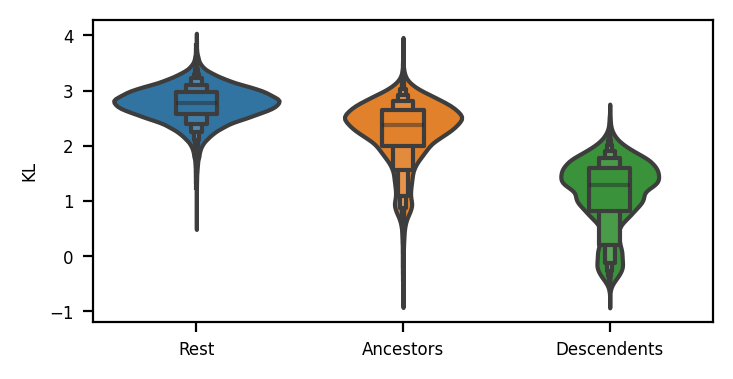

In [7]:
#@title Plot grouped KLs

fig, axs = plt.subplots(figsize=(4,2), dpi=200)
sns.violinplot(x='Partition', y='KL', data=dfa, inner=None)
sns.boxenplot(x='Partition', y='KL', data=dfa, width=.2, showfliers=False)
axs.set_xlabel('')

axs.tick_params(axis='both', 
                which='both',
                labelsize=6)

axs.set_ylabel('KL', fontsize=6)
plt.show()

#### Capture shortest path lengths

An important feature in graphs is the shortest length between nodes. Here, we evaluate whether the KL between Gaussian embeddings is able to capture the shortest path lengths.

To this aim, the KL between embeddings are grouped according to the shortest path lengths between nodes. The figure below shows the distribution of KLs after being grouped. It can be seen that the KL divergence is strongly correlated with the shortest path lengths.

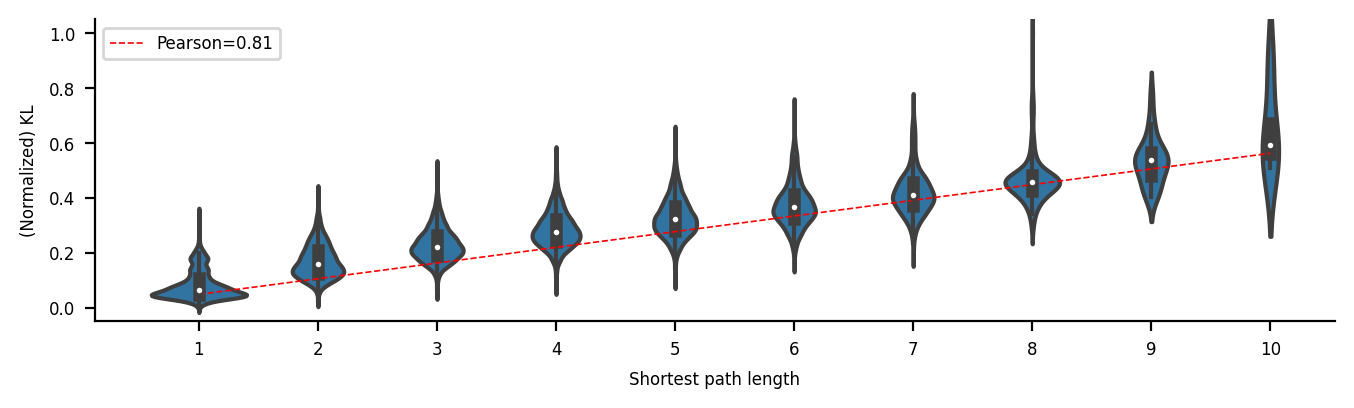

In [8]:
#@title Plot shortest path length vs KL
fig, axs = plt.subplots(figsize=(8,2), sharey=True, dpi=200)

pcor = scipy.stats.pearsonr(df.Length, df.KL)[0]
sns.violinplot(x="Length", 
               y="KL", 
               data=df, 
               ax=axs, 
               color='tab:blue')

b, a = np.polyfit(df.Length, df.KL, deg=1)
xspace = np.linspace(0, df.Length.max()-1, num=100)
axs.plot(xspace, 
         a + b * xspace, 
         color="red",
         linestyle='--',
         lw=.6,
         label=f'Pearson={pcor:.2f}', rasterized=True)

axs.tick_params(axis='both', which='both', labelsize=6) # change fontsize

loc='upper left'

axs.legend(loc=loc, prop={'size': 6})
axs.set_ylim([-0.05, 1.05])

axs.set_xticks(range(df.Length.astype(np.int32).max()))
axs.set_xticklabels(np.arange(df.Length.astype(np.int32).max())+1)

spine = 'right'
axs.spines[spine].set_visible(False)
axs.spines['top'].set_visible(False)

axs.set_ylabel('(Normalized) KL', fontsize=6)
axs.set_xlabel('Shortest path length', fontsize=6)

plt.subplots_adjust(wspace=0.03, hspace=0)
plt.show()